### 70. データの入手・整形
文に関する極性分析の正解データを用い，以下の要領で正解データ（sentiment.txt）を作成せよ．

1. rt-polarity.posの各行の先頭に"+1 "という文字列を追加する（極性ラベル"+1"とスペースに続けて肯定的な文の内容が続く）
2. rt-polarity.negの各行の先頭に"-1 "という文字列を追加する（極性ラベル"-1"とスペースに続けて否定的な文の内容が続く）
3. 上述1と2の内容を結合（concatenate）し，行をランダムに並び替える

sentiment.txtを作成したら，正例（肯定的な文）の数と負例（否定的な文）の数を確認せよ．

In [1]:
with open('data/sentiment.txt', 'w'):
    pass
with open('data/sentiment.txt', 'a')as a:
    for pos, neg in zip(open('data/rt-polarity.pos'), open('data/rt-polarity.neg')):
        a.write('+1 ' + pos)
        a.write('-1 ' + neg)

In [2]:
!sort data/sentiment.txt -R -o data/sentiment.txt

In [3]:
pos = 0
neg = 0
for line in open('data/sentiment.txt'):
    if line[:2] == '+1':
        pos = pos + 1
    else:
        neg = neg + 1
print(pos)
print(neg)

5331
5331


### 71. ストップワード
英語のストップワードのリスト（ストップリスト）を適当に作成せよ．さらに，引数に与えられた単語（文字列）がストップリストに含まれている場合は真，それ以外は偽を返す関数を実装せよ．さらに，その関数に対するテストを記述せよ．

ストップワード：自然言語を処理するにあたって一般的であるなどの理由で処理対象外とする単語

In [40]:
#ググって拾ってきた
stop_words=["(", ")", "--", ",", ".", ";", ":", "\'", "\"", "i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]
dif = ord('a')-ord('A')
stop_words = [chr(ord(i[0])-dif)+i[1:] for i in stop_words] + stop_words + [""]

In [41]:
def in_sw(word):
    if word in stop_words:
        return True
    else:
        return False

In [42]:
#test
for i in stop_words:
    if in_sw(i) == False:
        print('bloody hell!')
        break

### 72. 素性抽出
極性分析に有用そうな素性を各自で設計し，学習データから素性を抽出せよ．素性としては，レビューからストップワードを除去し，各単語をステミング処理したものが最低限のベースラインとなるであろう．

In [43]:
from stemming.porter2 import stem
import re
from collections import Counter

In [44]:
with open('data/file72', 'w'):
    pass
with open('data/file72', 'a')as a:
    for line in open('data/sentiment.txt'):
        a.write(' '.join([stem(word) for word in line[2:].split() if not in_sw(stem(word))]) + '\n')

In [47]:
words = []
for line in open('data/file72'):
    words = words + line.split()
count=Counter(words)
print(len(words))
del words

115042


In [53]:
[(i, count[i]) for i in count if count[i] > 500]

[('film', 1800),
 ('movi', 1543),
 ('like', 805),
 ('make', 611),
 ('stori', 536),
 ('one', 763)]

In [66]:
with open('data/features', 'w')as w:
    w.write('\n'.join([i for i in count if count[i] >= 10 and count[i] < 1000 ]))

In [69]:
len([i for i in count if count[i] >= 10 and count[i] < 1000 ])

2108

### 73. 学習
72で抽出した素性を用いて，ロジスティック回帰モデルを学習せよ．

In [187]:
import numpy as np
import scipy as sp

In [148]:
answer = []
for line in open('data/sentiment.txt'):
    answer.append(int(line[:2])/2+0.5)
answer = np.array(answer)

In [113]:
with open('data/features')as r:
    features = r.read().split()
print(len(features))

2108


In [240]:
matrix = np.zeros((10662, 2109))
matrix[:,0] = 1
for line, i in zip(open('data/file72'), range(10662)):
    for word in  line.split():
        if word in features:
            matrix[i][features.index(word) + 1] = 1

In [261]:
v = np.random.rand(2109)

#matrix[:,1:]=standardize(matrix[:,1:])

def standardize(x):
    mean = x.mean()
    std = x.std()
    return  (x - mean) / std 

def sigmoid(x):
    return 1/(1 + np.exp(-x))
sigmoids = np.frompyfunc(sigmoid, 1, 1)

N = 100
for _ in range(N):
    v = v + 0.001 * np.dot(answer - sigmoids(np.dot(matrix,v)), matrix)

### 74. 予測
73で学習したロジスティック回帰モデルを用い，与えられた文の極性ラベル（正例なら"+1"，負例なら"-1"）と，その予測確率を計算するプログラムを実装せよ．

→76へ

### 75. 素性の重み
73で学習したロジスティック回帰モデルの中で，重みの高い素性トップ10と，重みの低い素性トップ10を確認せよ．

In [282]:
lst75 = sorted(list(enumerate(list(v))), key = lambda x: x[1], reverse = True)

In [283]:
[features[i[0]-1] for i in lst75][:10]

['refresh',
 'quiet',
 'engross',
 'beauti',
 'unexpect',
 'glorious',
 'delight',
 'cinema',
 'witti',
 'solid']

In [284]:
[features[i[0]-1] for i in lst75][-10:]

['neither',
 'joke',
 'tour',
 'worst',
 'video',
 'fail',
 'dull',
 'lack',
 'bore',
 'bad']

### 76. ラベル付け
学習データに対してロジスティック回帰モデルを適用し，正解のラベル，予測されたラベル，予測確率をタブ区切り形式で出力せよ．

In [290]:
with open('data/file76', 'w'):
    pass
with open('data/file76', 'a')as a:
    for i, j in zip(answer, sigmoids(np.dot(matrix,v))):
        if j > 0.5:
            a.write(str(int(i)) + '\t' + str(1) + '\t' + str(j)+ '\n')
        else:
            a.write(str(int(i)) + '\t' + str(0) + '\t' + str(1 - j) + '\n')

### 77. 正解率の計測
76の出力を受け取り，予測の正解率，正例に関する適合率，再現率，F1スコアを求めるプログラムを作成せよ．

予測の正解率

In [294]:
lst = []
for line in open('data/file76'):
    x = line.split()
    if x[0] == x[1]:
        lst.append(True)
    else:
        lst.append(False)
print(len([i for i in lst if i == True])/len(lst)*100)

77.27443256424685


正例に関する適合率 (precision rate)：　正例を正例と予測できた数 / 正例と予測した数

In [297]:
lst = []
for line in open('data/file76'):
    x = line.split()
    if x[0] == '1' and x[1] == '1':
        lst.append(True)
    elif x[1] == '1':
        lst.append(False)
print(len([i for i in lst if i == True])/len(lst)*100)

76.75745307324254


再現率 (recall rate)：　正例を正例と予測できた数　/ 　実際の正例の数

In [298]:
lst = []
for line in open('data/file76'):
    x = line.split()
    if x[0] == '1' and x[1] == '1':
        lst.append(True)
    elif x[0] == '1':
        lst.append(False)
print(len([i for i in lst if i == True])/len(lst)*100)

78.24048021009192


F1スコア　適合率と再現率の調和平均 = ( 2 * 適合率　* 再現率 ) / ( 適合率 + 再現率 )

In [299]:
a=76.75745307324254
b=78.24048021009192
print((2 * a * b) / (a + b))

77.49187180678123


### 78. 5分割交差検定
76-77の実験では，学習に用いた事例を評価にも用いたため，正当な評価とは言えない．すなわち，分類器が訓練事例を丸暗記する際の性能を評価しており，モデルの汎化性能を測定していない．そこで，5分割交差検定により，極性分類の正解率，適合率，再現率，F1スコアを求めよ．

4/5で訓練して1/5でテストする

In [300]:
10662/5

2132.4

In [303]:
matrix1of5 = matrix[:2133]
matrix4of5 = matrix[2133:]
answer1of5 = answer[:2133]
answer4of5 = answer[2133:]

In [306]:
v2 = np.random.rand(2109)

N = 100
for _ in range(N):
    v2 = v2 + 0.001 * np.dot(answer4of5 - sigmoids(np.dot(matrix4of5,v2)), matrix4of5)

In [307]:
with open('data/file78', 'w'):
    pass
with open('data/file78', 'a')as a:
    for i, j in zip(answer1of5, sigmoids(np.dot(matrix1of5,v2))):
        if j > 0.5:
            a.write(str(int(i)) + '\t' + str(1) + '\t' + str(j)+ '\n')
        else:
            a.write(str(int(i)) + '\t' + str(0) + '\t' + str(1 - j) + '\n')

正解率

In [316]:
lst = []
for line in open('data/file78'):
    x = line.split()
    if x[0] == x[1]:
        lst.append(True)
    else:
        lst.append(False)
print(len([i for i in lst if i == True])/len(lst)*100)

71.0267229254571


適合率

In [313]:
lst = []
for line in open('data/file78'):
    x = line.split()
    if x[0] == '1' and x[1] == '1':
        lst.append(True)
    elif x[1] == '1':
        lst.append(False)
print(len([i for i in lst if i == True])/len(lst)*100)

70.54337464251668


再現率

In [317]:
lst = []
for line in open('data/file78'):
    x = line.split()
    if x[0] == '1' and x[1] == '1':
        lst.append(True)
    elif x[0] == '1':
        lst.append(False)
print(len([i for i in lst if i == True])/len(lst)*100)

70.54337464251668


F1

In [315]:
a=70.54337464251668
b=70.54337464251668
print((2 * a * b) / (a + b))

70.54337464251668


### 79. 適合率-再現率グラフの描画
ロジスティック回帰モデルの分類の閾値を変化させることで，適合率-再現率グラフを描画せよ．

In [320]:
import matplotlib.pyplot as plt

In [363]:
with open('data/file79', 'w'):
    pass
with open('data/file79', 'a')as a:
    for i, j in zip(answer1of5, sigmoids(np.dot(matrix1of5,v2))):
        a.write(str(int(i)) + '\t' + str(1) + '\t' + str(j)+ '\n')

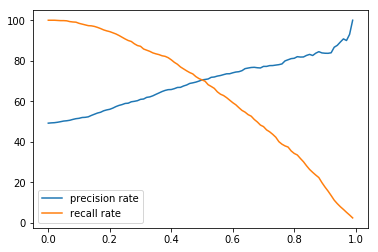

In [366]:
def precision_rate(lst79):
    lst=[]
    for x in lst79:
        if x[0] == 1 and x[1] == 1:
            lst.append(True)
        elif x[1] == 1:
            lst.append(False)
    return len([i for i in lst if i == True])/len(lst)*100

def recall_rate(lst79):
    lst=[]
    for x in lst79:
        if x[0] == 1 and x[1] == 1:
            lst.append(True)
        elif x[0] == 1:
            lst.append(False)
    return len([i for i in lst if i == True])/len(lst)*100

def f79(x):
    lst79 = []
    for line in open('data/file79'):
        data = line.split()
        i, j = int(data[0]), float(data[2])
        if j > x:
            lst79.append([i, 1])
        else:
            lst79.append([i, 0])
    #print(lst79)
    return precision_rate(lst79), recall_rate(lst79)

f = np.frompyfunc(f79, 1, 2)

X = np.linspace(0, 1, 100, endpoint = False)
p, r = f(X)
plt.plot(X, p, label = 'precision rate')
plt.plot(X, r, label = 'recall rate')
plt.legend()
plt.show()